In [10]:
# Installing Transformers

!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [11]:
# Install Torch

!pip install torch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [12]:
# Install Sentencepiece

!pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [13]:
!pip install -q -U watermark

In [14]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

Python implementation: CPython
Python version       : 3.8.10
IPython version      : 7.9.0

numpy       : 1.21.6
pandas      : 1.3.5
torch       : 1.13.1+cu116
transformers: 4.26.1



In [15]:
!nividia_smi

/bin/bash: nividia_smi: command not found


In [16]:
# memory footprint support libraries/code

!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [17]:
import psutil
import humanize
import os
import GPUtil as GPU

GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
    process = psutil.Process(os.getpid())
    print("Gen RAM Free: " + humanize.naturalsize(psutil.virtual_memory().available), " |     Proc size: " + humanize.naturalsize(process.memory_info().rss))
    print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total     {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

Gen RAM Free: 87.7 GB  |     Proc size: 773.1 MB
GPU RAM Free: 40536MB | Used: 0MB | Util   0% | Total     40960MB


In [18]:
# Import Required Transformer Libraries

import transformers
from transformers import XLNetTokenizer, XLNetModel, AdamW, get_linear_schedule_with_warmup
import torch

# Import Required Standard Libraries 

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from pylab import rcParams
import random
import re
from keras.layers import Embedding

# Import Required Torch Libraries

from torch import nn, optim
from tensorflow.keras.preprocessing.sequence import pad_sequences
from torch.utils.data import TensorDataset,RandomSampler,SequentialSampler
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

In [19]:
from seaborn import palettes
# Setting The Theme For The Visualizations

%matplotlib inline
%config InlineBackend.figur_format = 'retina'

sns.set(
    style = 'whitegrid',
    palette = 'muted',
    font_scale = 1.2
)

HAPPY_COLORS_PALETTE = [
                        '#01BEFE',
                        '#FFDD00',
                        '#FF7D00',
                        '#FF006D',
                        '#ADFF02',
                        '#8F00FF']

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 12

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [20]:
# Reading The Dataset

path_to_data = "/content/stanfordMOOCForumPostsSet.csv"
modelDataset = pd.read_csv(path_to_data)


modelDataset.rename(columns = {
    'Text': 'text',
    'Sentiment(1-7)': 'Sentiment',
    'Confusion(1-7)': 'Confusion',
    'Urgency(1-7)' : 'Urgency'
}, inplace = True)
modelDataset.head()

,text,Opinion(1/0),Question(1/0),Answer(1/0),Sentiment,Confusion,Urgency,CourseType,forum_post_id,course_display_name,forum_uid,created_at,post_type,anonymous,anonymous_to_peers,up_count,comment_thread_id,reads
0,Interesting! How often we say those things to ...,1,0,0,6.5,2.0,1.5,Education,5225177f2c501f0a00000015,Education/EDUC115N/How_to_Learn_Math,30CADB93E6DE4711193D7BD05F2AE95C,2013-09-02 22:55,Comment,False,False,0.0,5221a8262cfae31200000001,41.0
1,"What is \Algebra as a Math Game\"" or are you j...",0,1,0,4.0,5.0,3.5,Education,5207d0e9935dfc0e0000005e,Education/EDUC115N/How_to_Learn_Math,37D8FAEE7D0B94B6CFC57D98FD3D0BA5,2013-08-11 17:59,Comment,False,False,0.0,520663839df35b0a00000043,55.0
2,I like the idea of my kids principal who says ...,1,0,0,5.5,3.0,2.5,Education,52052c82d01fec0a00000071,Education/EDUC115N/How_to_Learn_Math,CC11480215042B3EB6E5905EAB13B733,2013-08-09 17:53,Comment,False,False,0.0,51e59415e339d716000001a6,25.0
3,"From their responses, it seems the students re...",1,0,0,6.0,3.0,2.5,Education,5240a45e067ebf1200000008,Education/EDUC115N/How_to_Learn_Math,C717F838D10E8256D7C88B33C43623F1,2013-09-23 20:28,CommentThread,False,False,0.0,None,0.0
4,"The boys loved math, because \there is freedom...",1,0,0,7.0,2.0,3.0,Education,5212c5e2dd10251500000062,Education/EDUC115N/How_to_Learn_Math,F83887D68EA48964687C6441782CDD0E,2013-08-20 1:26,CommentThread,False,False,0.0,None,3.0


In [21]:
modelDataset = modelDataset[:29000]
len(modelDataset)

29000

In [22]:
# Function to Clean text, remove tagged entities, hyperlinks, emojis

def clean_text_data(text):
  text = re.sub(r"@[A-Za-z0-9]+", ' ', text)
  text = re.sub(r"https?://[A-Za-z0-9./]+", ' ', text)
  text = re.sub(r"[^a-zA-z.!?'0-9]", ' ', text)
  text = re.sub('\t', ' ', text)
  text = re.sub(r" +", ' ', text)
  return text

In [23]:
modelDataset['text'] = modelDataset['text'].apply(clean_text_data)

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


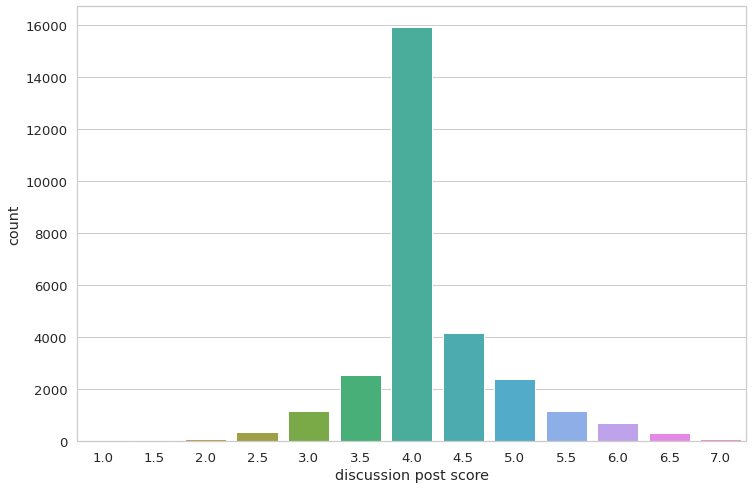

In [24]:
rcParams['figure.figsize'] = 12, 8
sns.countplot(modelDataset.Sentiment)
plt.xlabel('discussion post score')
plt.show()

In [25]:
#  Assign Labels to Sentiments:
""" 
  Reference for labels where obtained from: 
  https://towardsdatascience.com/fine-grained-sentiment-analysis-in-python-part-1-2697bb111ed4
"""

def sentiment2label(sentiment):
  if sentiment <= 1:
    return 'Strongly Negative'
  elif ((sentiment > 1) and (sentiment <= 2)):
    return 'Weakly Negative' 
  elif ((sentiment > 2) and (sentiment <= 3)):
    return 'Netural'
  elif ((sentiment > 3) and (sentiment <= 4)):
    return 'Weakly Positive'
  elif ((sentiment > 4) and (sentiment <= 7)):
    return 'Strongly positive'

In [26]:
modelDataset['Sentiment_label'] = modelDataset['Sentiment'].apply(sentiment2label)


In [27]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
modelDataset['Sentiment_label'] = label_encoder.fit_transform(modelDataset['Sentiment_label'])

In [28]:
modelDataset['Sentiment'].value_counts()

4.0    15937
4.5     4184
3.5     2568
5.0     2386
5.5     1182
3.0     1156
6.0      686
2.5      352
6.5      310
2.0       97
7.0       82
1.5       46
1.0       14
Name: Sentiment, dtype: int64

In [29]:
class_names = [
               'Strongly Negative',
               'Weakly Negative',
               'Netural',
               'Weakly Positive',
               'Strongly positive'
]

In [30]:
# Encode and Pad Data

from transformers import XLNetTokenizer

tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased')

In [31]:
input_txt = 'What is \Algebra as a Math Game\ or are you just saying you create games that incorporate algebra.'

encodings = tokenizer.encode_plus(input_txt,
                                 add_special_tokens = True,
                                 max_length = 16,
                                 return_tensors = 'pt',
                                 return_token_type_ids = False,
                                 return_attention_mask = True,
                                 pad_to_max_length = True
                                 )

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2339: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [32]:
print('Input_ids:', encodings['input_ids'])

Input_ids: tensor([[  609,    27,    17, 17666,  3869,  1207,  3890,    34,    24, 10300,
          3645, 17666,    49,    41,     4,     3]])


In [33]:
tokenizer.convert_ids_to_tokens(encodings['input_ids'][0])

['▁What',
 '▁is',
 '▁',
 '\\',
 'Al',
 'ge',
 'bra',
 '▁as',
 '▁a',
 '▁Math',
 '▁Game',
 '\\',
 '▁or',
 '▁are',
 '<sep>',
 '<cls>']

In [34]:
type(encodings['attention_mask'])

torch.Tensor

In [35]:
attention_mask = pad_sequences(encodings['attention_mask'],
                               maxlen = 512,
                               dtype = torch.Tensor,
                               truncating = 'post',
                               padding = 'post'
                               )

In [36]:
attention_mask = attention_mask.astype(dtype = 'int64')
attention_mask = torch.tensor(attention_mask)
attention_mask.flatten()

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [37]:
encodings['input_ids']

tensor([[  609,    27,    17, 17666,  3869,  1207,  3890,    34,    24, 10300,
          3645, 17666,    49,    41,     4,     3]])

In [38]:
# Reviewing The Distribution of Token Lengths

token_lens = []

for txt in modelDataset['text']:
  tokens = tokenizer.encode(txt, max_length = 512)
  token_lens.append(len(tokens))

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


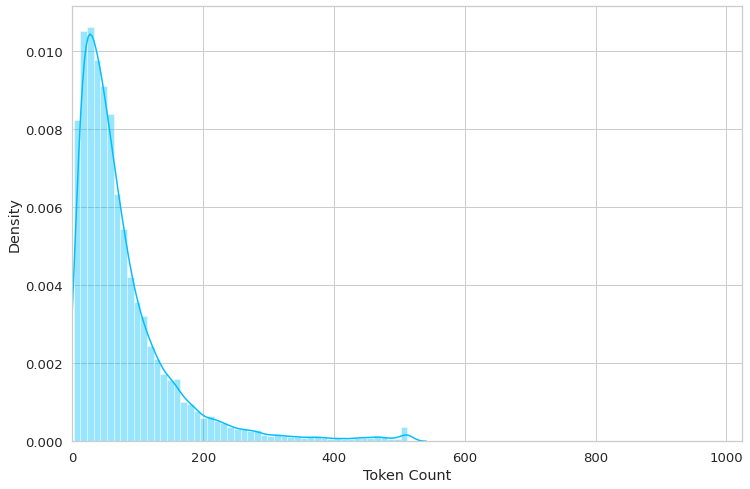

In [39]:
rcParams['figure.figsize'] = 12, 8

sns.distplot(token_lens)
plt.xlim([0,  1024])
plt.xlabel('Token Count')
plt.show()

In [40]:
MAX_LEN = 512

In [41]:
# Custom Dataset Class

class stanfordDataset(Dataset):

  def __init__(self, texts, targets, tokenizer, max_len):
      self.texts = texts
      self.targets = targets
      self.tokenizer = tokenizer
      self.max_len = max_len

  def __len__(self):
      return len(self.texts)

  def __getitem__(self, item):
      text = str(self.texts[item])
      target = self.targets[item]

      encoding = self.tokenizer.encode_plus(
          text,
          add_special_tokens = True,
          max_length = self.max_len,
          pad_to_max_length = False,
          return_attention_mask = True,
          return_tensors = 'pt'
      )

      input_ids = pad_sequences(encoding['input_ids'],
                                maxlen = MAX_LEN,
                                dtype = torch.Tensor,
                                truncating = 'post',
                                padding = 'post'
                                )
      input_ids = input_ids.astype(dtype = 'int64')
      input_ids = torch.tensor(input_ids)
      
      attention_mask = pad_sequences(encoding['attention_mask'],
                                     maxlen = MAX_LEN,
                                     dtype = torch.Tensor,
                                     truncating = 'post',
                                     padding = 'post'
                                     )
      attention_mask = attention_mask.astype(dtype = 'int64')
      attention_mask = attention_mask.astype (dtype = 'int64')
      attention_mask = torch.tensor(attention_mask)
      
      return {
          'input_text': text,
          'input_ids': input_ids,
          'attention_mask': attention_mask.flatten(),
          'targets': torch.tensor(target, dtype = torch.long)
      }


In [42]:
modelDataset.shape

(29000, 19)

In [43]:
modelDataset_train, modelDataset_test = train_test_split(modelDataset,
                                                         test_size = 0.5,
                                                         random_state = 101)
modelDataset_val, modelDataset_test = train_test_split(modelDataset_test,
                                                       test_size = 0.5,
                                                       random_state = 101)

In [44]:
modelDataset_train.shape, modelDataset_val.shape, modelDataset_test.shape

((14500, 19), (7250, 19), (7250, 19))

In [45]:
# Custom Dataloader

def create_data_loader(modelDataset, tokenizer, max_len, batch_size):
  ds = stanfordDataset(
      texts = modelDataset.text.to_numpy(),
      targets = modelDataset.Sentiment_label.to_numpy(),
      tokenizer = tokenizer,
      max_len = max_len
  )

  return DataLoader(
      ds,
      batch_size = batch_size,
      num_workers = 2
  )

In [46]:
BATCH_SIZE = 4

train_data_loader = create_data_loader(
    modelDataset_train,
    tokenizer, 
    MAX_LEN, 
    BATCH_SIZE
)

val_data_loader = create_data_loader(
    modelDataset_val,
    tokenizer, 
    MAX_LEN, 
    BATCH_SIZE
)

test_data_loader = create_data_loader(
    modelDataset_test,
    tokenizer, 
    MAX_LEN, 
    BATCH_SIZE
)

In [47]:
# Load the Pre-trained XLNet Model For Sequencec Classification From
# Huggingface Transformers

from transformers import XLNetForSequenceClassification

model = XLNetForSequenceClassification.from_pretrained(
    'xlnet-base-cased',
    num_labels = 5
)
model = model.to(device)

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.bias', 'lm_loss.weight']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['sequence_summary.summary.weight', 'sequence_summary.summary.bias', 'logits_proj.bias', 'logits_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions a

In [48]:
model

XLNetForSequenceClassification(
  (transformer): XLNetModel(
    (word_embedding): Embedding(32000, 768)
    (layer): ModuleList(
      (0): XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (layer_1): Linear(in_features=768, out_features=3072, bias=True)
          (layer_2): Linear(in_features=3072, out_features=768, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (activation_function): GELUActivation()
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (1): XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward

In [49]:
# Setting Hyperparameters

EPOCHS = 3

param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
                                {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
                                {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay':0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, 
                  no_deprecation_warning = True,
                  lr = 3e-5)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer, 
    num_warmup_steps = 0,
    num_training_steps = total_steps
)

In [50]:
data = next(iter(val_data_loader))
data.keys()

dict_keys(['input_text', 'input_ids', 'attention_mask', 'targets'])

In [51]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)
targets = data['targets'].to(device)
print(input_ids.reshape(-1, 512).shape) # Batch size x seq length
print(attention_mask.shape) # Batch size x seq length

torch.Size([4, 512])
torch.Size([4, 512])


In [52]:
input_ids[0]

tensor([[  311,  1846,    25,    18,   527,  5931,    75,    18, 22146,  2018,
          3120,    20,  1927,  1350,    35,    30,    50,  3600,     9,    32,
          1150,  1155,    17,  6200,    68,    33,    24,  2342,    35,   828,
            75,   242,  7999,  1799,     9,    67,    24,  2342,    20,   956,
         11035,  3434,    21,  2537,  6056,   506,    22,   613,    63,    54,
            71,   427,  1851,  2167,    31,    18,  2018,  3120,    20,  7999,
             9,   394,   166,  2167,    55, 22146,     9,   311,   502,    18,
          1427,    29,   105,    54,    72,   396,  2841,  4410,  1995,    20,
          3434,    21,  2421,    20,  2537,    42,    29,  7999,    25,    52,
           363,    30,  7884,     9,  1867,    18,  3553,    29,    18,  2001,
          1188,    24,   434,    20,   356,    31,    18,  1615,  4657,    20,
          2537,    21,  5426,    20,  3434,    42,    29,  7999,    30,  4968,
             9,   183,    18,  1259,    54,    72,  

In [53]:
outputs = model(input_ids.reshape(-1, 512),
                taken_type_ids = None,
                attention_mask = attention_mask,
                labels = targets)
outputs

XLNetForSequenceClassificationOutput(loss=tensor(1.9946, device='cuda:0', grad_fn=<NllLossBackward0>), logits=tensor([[ 0.1185,  0.0376,  0.3861, -0.3053, -0.1564],
        [ 0.4118,  0.0876,  0.5407, -0.3524, -0.5417],
        [ 0.1483, -0.0718,  0.4339, -0.1837, -0.3388],
        [ 0.4823,  0.1451,  0.2480, -0.4338, -0.5277]], device='cuda:0',
       grad_fn=<AddmmBackward0>), mems=(tensor([[[-0.0367, -0.0459,  0.0047,  ..., -0.0308, -0.0463, -0.0509],
         [ 0.0223, -0.0020,  0.1109,  ..., -0.0375,  0.0828, -0.0054],
         [ 0.0260, -0.0055, -0.0362,  ..., -0.0377,  0.0107, -0.0200],
         [-0.1145, -0.0398,  0.0765,  ..., -0.0867,  0.0429,  0.0449]],

        [[ 0.0365,  0.0772,  0.0758,  ..., -0.0005, -0.0665, -0.0687],
         [ 0.0338, -0.0068, -0.0029,  ...,  0.0509, -0.0262, -0.0278],
         [ 0.0008,  0.0242, -0.0275,  ...,  0.0137,  0.0304, -0.0418],
         [ 0.0257,  0.0011, -0.0448,  ..., -0.0297,  0.0106, -0.0088]],

        [[ 0.0155,  0.0256, -0.0233,  ..

In [54]:
type(outputs[0])

torch.Tensor

In [55]:
# Defining The Training Function

from sklearn import metrics

def train_epoch(model, data_loader, optimizer, device, scheduler, n_examples):
  
  model = model.train()
  losses = []
  acc = 0
  counter = 0

  for d in data_loader:
    input_ids = d['input_ids'].reshape(-1, 512).to(device)
    attention_mask = d['attention_mask'].to(device)
    targets = d['targets'].to(device)

    outputs = model(input_ids = input_ids,
                    token_type_ids = None,
                    attention_mask = attention_mask,
                    labels = targets)
    loss = outputs[0]
    logits = outputs[1]

    _, prediction = torch.max(outputs[1], dim = 1)
    targets = targets.cpu().detach().numpy()
    prediction = prediction.cpu().detach().numpy()
    accuracy = metrics.accuracy_score(targets, prediction)

    acc += accuracy
    losses.append(loss.item())

    loss.backward()

    nn.utils.clip_grad_norm_(model.parameters(), max_norm = 1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()
    counter = counter + 1

  return acc / counter, np.mean(losses)

In [56]:
# Defining The Evaluation Function 

def eval_model(model, data_loader, device, n_examples):
  model = model.eval()
  losses = []
  acc = 0
  counter = 0


  with torch.no_grad():
    for d in data_loader:
      input_ids = d['input_ids'].reshape(-1, 512).to(device)
      attention_mask = d['attention_mask'].to(device)
      targets = d['attention_mask'].to(device)
      targets = d['targets'].to(device)

      outputs = model(input_ids = input_ids, 
                      token_type_ids = None,
                      attention_mask = attention_mask,
                      labels = targets)
      loss = outputs[0]
      logits = outputs[1]

      _, prediction = torch.max(outputs[1], dim = 1)
      targets = targets.cpu().detach().numpy()
      prediction = prediction.cpu().detach().numpy()
      accuracy = metrics.accuracy_score(targets, prediction)

      acc += accuracy
      losses.append(loss.item())
      counter += 1

  return acc / counter, np.mean(losses)

In [57]:
# Fine-tuning The Pre-trained Model

%%time
history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):
  print(f'Epoch {epoch + 1} / {EPOCHS}')
  print('_' * 10)

  train_acc, train_loss = train_epoch(
      model,
      train_data_loader,
      optimizer,
      device,
      scheduler,
      len(modelDataset_train)
  )

  print(f'Train loss {train_loss} Train accuracy {train_acc}')

  val_acc, val_loss = eval_model(
      model,
      val_data_loader,
      device,
      len(modelDataset_val)
  )

  print(f'Val loss {val_loss} Val accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), '/content/XLNET_NLP_Model.pt')
    best_accuracy = val_acc

Epoch 1 / 3
__________
Train loss 0.6897029952914293 Train accuracy 0.7837931034482759
Val loss 0.603693439216562 Val accuracy 0.8208769994484281

Epoch 2 / 3
__________
Train loss 0.5760823817197555 Train accuracy 0.8480689655172414
Val loss 0.7190677844739473 Val accuracy 0.8174296745725317

Epoch 3 / 3
__________
Train loss 0.4368505052607828 Train accuracy 0.9008275862068965
Val loss 0.8614862620150151 Val accuracy 0.8164644236072808

CPU times: user 37min 54s, sys: 5min 31s, total: 43min 25s
Wall time: 33min 23s


In [58]:
# Evaluation of The Fine-tuned Model

model.load_state_dict(torch.load('/content/XLNET_NLP_Model.pt'))

<All keys matched successfully>

In [59]:
model = model.to(device)

In [60]:
test_acc, test_loss = eval_model(
    model,
    test_data_loader,
    device,
    len(modelDataset_test)
)

print('Test Accuracy: ', test_acc)
print('Test Loss:', test_loss)

Test Accuracy:  0.8121897407611693
Test Loss: 0.6243473817298977


In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()

  data_text = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d['input_text']
      input_ids = d['input_ids'].reshape(-1, 512).to(device)
      attention_mask = d['attention_mask'].to(device)
      targets = d['targets'].to(device)

      outputs = model(input_ids = input_ids,
                      token_type_ids = None,
                      attention_mask=attention_mask, 
                      labels = targets)
      
      loss = outputs[0]
      logits = outputs[1]

      _, preds = torch.max(outputs[1], dim = 1)

      probs = F.softmax(outputs[1], dim = 1)

      data_text.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)
  
  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return data_text, predictions, prediction_probs, real_values

In [ ]:
y_data_texts, y_pred, y_pred_probbs, y_test = get_predictions(
    model, 
    test_data_loader
)

In [71]:
print(classification_report(y_test, 
                            y_pred, 
                            target_names = class_names))

                   precision    recall  f1-score   support

Strongly Negative       0.49      0.23      0.31       390
  Weakly Negative       0.00      0.00      0.00         3
          Netural       0.78      0.77      0.77      2185
  Weakly Positive       0.00      0.00      0.00        36
Strongly positive       0.84      0.89      0.86      4636

         accuracy                           0.81      7250
        macro avg       0.42      0.38      0.39      7250
     weighted avg       0.80      0.81      0.80      7250



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [64]:
# Custom predicition on raw text

def predict_sentiment(text):
  input_text = text

  encoded_text = tokenizer.encode_plus(
      input_text,
      max_length = MAX_LEN,
      add_special_tokens = True,
      return_token_type_ids = False,
      pad_to_max_length = False,
      return_attention_mask = True,
      return_tensors = 'pt',
  )

  input_ids = pad_sequences(encoded_text['input_ids'], 
                            maxlen=MAX_LEN, dtype=torch.Tensor,
                            truncating="post",padding="post")
  input_ids = input_ids.astype(dtype = 'int64')
  input_ids = torch.tensor(input_ids)
  
  attention_mask = pad_sequences(encoded_text['attention_mask'], 
                                 maxlen=MAX_LEN, dtype=torch.Tensor ,
                                 truncating="post",padding="post")
  attention_mask = attention_mask.astype(dtype = 'int64')
  attention_mask = torch.tensor(attention_mask)

  input_ids = input_ids.reshape(-1, 512).to(device)
  attention_mask = attention_mask.to(device)

  outputs = model(
      input_ids = input_ids, 
      attention_mask = attention_mask
  )

  outputs = outputs[0][0].cpu().detach()

  probs = F.softmax(outputs, dim = -1).cpu().detach().numpy().tolist()
  _, prediction = torch.max(outputs, dim = -1)

  print('Positive score:', probs[1])
  print('Negative score:', probs[0])
  print(f'Input text: {input_text}')
  print(f'Sentiment: {class_names[prediction]}')

In [ ]:
text = 'Hello! In my opinion I prefer to use Graph pad prism above spss and other statistics software.  This software combines scientific graphing, comprehensive curve fitting, understandable statistics, and data organization. Prism is now used much more broadly by all kinds of biologists, as well as social and physical scientists.'
predict_sentiment(text)

In [ ]:
text = 'I cant see any reason to exclude Excel for small datasets that wouldnt also apply to most other software   lets say you send me an Excel spreadsheet  1) you and I have different versions  2) I may not have that software even installed  3) it costs too much for me to buy 4) it doesnt run on linux (or possibly Mac)   but like I said, those reasons apply to almost any software   R of course if free,  runs on windows, linux and Mac  but the learning curve may be more difficult than Excel'
predict_sentiment(text)

In [67]:
text = 'I am not looking for an alternative to R. I am fine with R. I was wondering how statistics was going to be taught without any open source software for commonality of use and explanation. Also discussion of model answers to home works.'
predict_sentiment(text)

Positive score: 7.68995305406861e-05
Negative score: 0.015200414694845676
Input text: I am not looking for an alternative to R. I am fine with R. I was wondering how statistics was going to be taught without any open source software for commonality of use and explanation. Also discussion of model answers to home works.
Sentiment: Strongly positive


In [68]:
text = 'nonsense'
predict_sentiment(text)

Positive score: 2.7505393518367782e-05
Negative score: 0.0010465324157848954
Input text: nonsense
Sentiment: Strongly positive


In [69]:
text = 'I seem to remember reading somewhere ages ago that Excel can introduce significant errors and shouldnt be used at all for what we could call serious analyses (i.e. for publications). Since there are so many much better free packages available, it makes sense *not* to use it in my opinion. Doing these simple calculations by hand also reinforces the concept - the mere fact of physically using your hands helps memory, apparently. I just finished a course on Special Relativity, lots of equations, and I can say it certainly did help using paper and pencil.'
predict_sentiment(text)

Positive score: 7.87795870564878e-05
Negative score: 0.015092993155121803
Input text: I seem to remember reading somewhere ages ago that Excel can introduce significant errors and shouldnt be used at all for what we could call serious analyses (i.e. for publications). Since there are so many much better free packages available, it makes sense *not* to use it in my opinion. Doing these simple calculations by hand also reinforces the concept - the mere fact of physically using your hands helps memory, apparently. I just finished a course on Special Relativity, lots of equations, and I can say it certainly did help using paper and pencil.
Sentiment: Strongly positive


In [70]:
text = 'excel is great but it does not have built in functions for nonparamatric tests as well as anova, but I could be wrong. example include Wilcoxon rank-sum, spearman correlation, testing for homogeneity  to name a few.'
predict_sentiment(text)

Positive score: 3.5120625398121774e-05
Negative score: 0.0036532843951135874
Input text: excel is great but it does not have built in functions for nonparamatric tests as well as anova, but I could be wrong. example include Wilcoxon rank-sum, spearman correlation, testing for homogeneity  to name a few.
Sentiment: Strongly positive
